# Super Spring Ultra Pro Max XXL

See Exercise 4.4 for the full statement.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from lampe.plots import *

## Markov model

In [76]:
variables = ['position', 'velocity', 'acceleration', 'wind']

dt = 0.1
rho, kappa, eta = 0.1, 0.5, 0.1
alpha = 0.95
sigma_w = 10.0
sigma_e = 2.0

### Gaussian prior

$$p(x_0) = \mathcal{N}(x_0 | \mu_0, \Sigma_0)$$

In [77]:
mu_0 = np.array([10.0, 0, 0, 0])

Sigma_0 = np.array([
    [0.5**2, 0, 0, 0],
    [0, 0.1**2, 0, 0],
    [0, 0, 0.1**2, 0],
    [0, 0, 0, sigma_w**2 / (1 - alpha**2)],
])

def prior(n_samples=None):
    return np.random.multivariate_normal(mu_0, Sigma_0, size=n_samples)

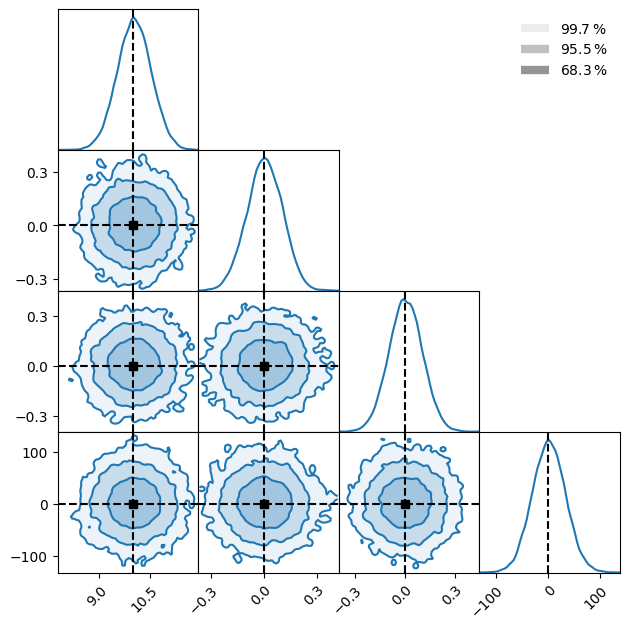

In [78]:
samples = prior(16384)
f = corner(samples, smooth=1.)
mark_point(f, mu_0)
plt.show()

### Linear Gaussian transition model

$$p(x_t \vert x_{t - 1}) = \mathcal{N}(x_t | F x_{t - 1} + u, \Sigma_x)$$

In [79]:
F = np.array([
    [1, dt, dt**2 / 2, 0],
    [0, 1, dt, 0],
    [-kappa, -eta, 0, rho],
    [0, 0, 0, alpha],
])

u = np.array([0, 0, 0, 0])

Sigma_x = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, sigma_w**2]
])

def transition(x, n_samples=None):
    return np.random.multivariate_normal(F @ x + u, Sigma_x, size=n_samples)

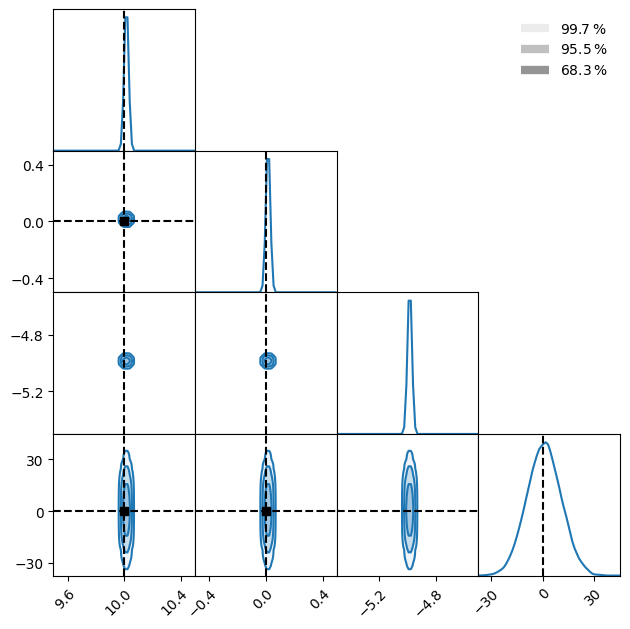

In [80]:
samples = transition(mu_0, 16384)
f = corner(samples, smooth=1.)
mark_point(f, mu_0)
plt.show()

### Linear Gaussian sensor model

$$p(e_t \vert x_t) = \mathcal{N}(e_t | H x_t + v, \Sigma_e)$$

In [81]:
H = np.array([[0, 0, 1, 0]])

v = np.array([0])

Sigma_e = np.array([[sigma_e**2]])

def sensor(x, n_samples=None):
    return np.random.multivariate_normal(H @ x + v, Sigma_e, size=n_samples)

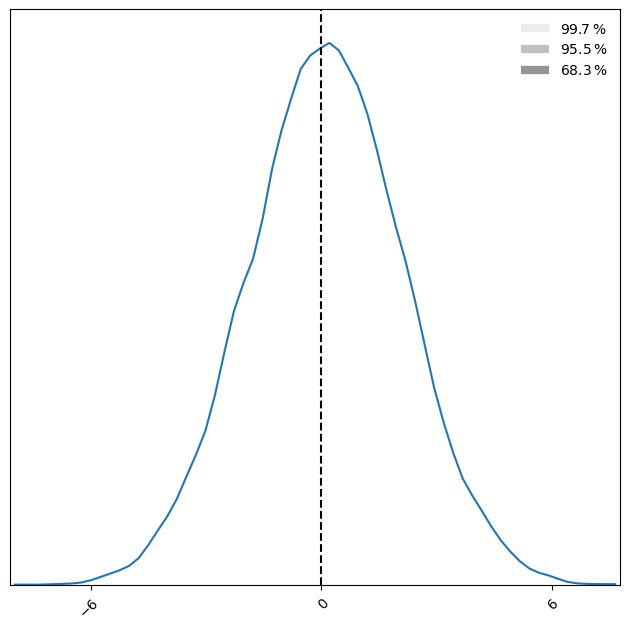

In [82]:
samples = sensor(mu_0, 16384)
f = corner(samples, smooth=1.)
mark_point(f, mu_0[-2][np.newaxis])
plt.show()

## Generation

In [83]:
def generate(steps):
    T = dt * np.arange(steps)
    X = [prior()]
    E = []

    for t in T[1:]:
        x = X[-1]
        x = transition(x)
        e = sensor(x)

        X.append(x)
        E.append(e)

    return T, np.stack(X), np.stack(E)

In [84]:
T, X, E = generate(1200)

## Kalman filtering

In [85]:
def predict(mu, Sigma):
    return (
        F @ mu + u,
        F @ Sigma @ F.T + Sigma_x,
    )

def update(mu, Sigma, e):
    K = Sigma @ H.T @ np.linalg.inv(H @ Sigma @ H.T + Sigma_e)
    
    return (
        mu + K @ (e - H @ mu - v),
        Sigma - K @ H @ Sigma
    )

def kalman_filter(E):
    MU = [mu_0]
    SIGMA = [Sigma_0]
    
    for e in E:
        mu, Sigma = MU[-1], SIGMA[-1]
        mu, Sigma = predict(mu, Sigma)
        mu, Sigma = update(mu, Sigma, e)

        MU.append(mu)
        SIGMA.append(Sigma)
        
    return np.stack(MU), np.stack(SIGMA)

In [86]:
MU, SIGMA = kalman_filter(E)

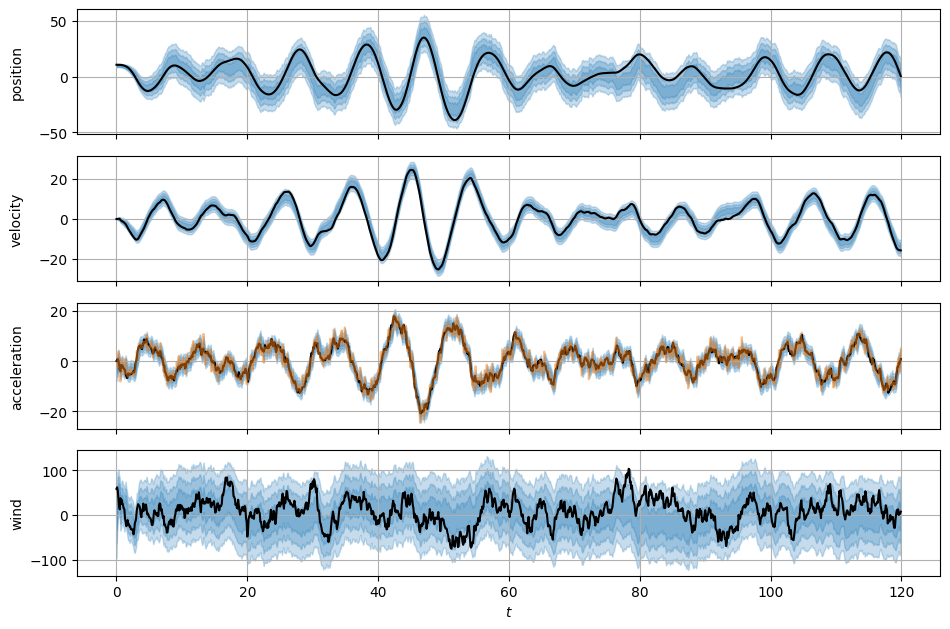

In [87]:
fig, axs = plt.subplots(4, figsize=(9.6, 6.4))

for i in range(4):
    axs[i].plot(T, X[:, i], 'k')
    
    for j in (3, 2, 1):
        axs[i].fill_between(T, MU[:, i] - j * np.sqrt(SIGMA[:, i, i]), MU[:, i] + j * np.sqrt(SIGMA[:, i, i]), color='C0', alpha=0.25)

    if i == 2:
        axs[i].plot(T[1:], E[:, 0], 'C1', alpha=0.5)
    
    axs[i].grid()
    axs[i].set_xlabel(r'$t$')
    axs[i].set_ylabel(variables[i])
    axs[i].label_outer()

fig.align_labels()
fig.tight_layout()